In [2]:
import numpy as np 
import pandas as pd 

In [3]:
df = pd.read_csv("data/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [4]:
df.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [5]:
df.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

In [6]:
data = df.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word',"pos"],axis=1)

In [7]:
data.head()

,sentence_idx,shape,word,tag
0,1.0,capitalized,Thousands,O
1,1.0,lowercase,of,O
2,1.0,lowercase,demonstrators,O
3,1.0,lowercase,have,O
4,1.0,lowercase,marched,O


In [8]:
data = data.drop(['shape'],axis=1)

In [9]:
data.head()

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O


In [10]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(data)

In [12]:
sentences = getter.sentences

In [13]:
print(sentences[0])

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O'), ('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [14]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

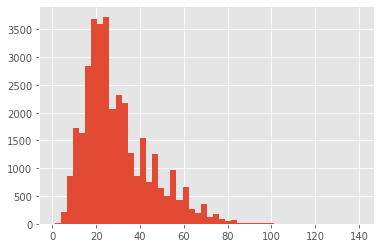

In [17]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [19]:
words = list(set(data["word"].values))
words.append("ENDPAD")

In [28]:
n_words = len(words); n_words

30174

In [29]:
tags = list(set(data["tag"].values))

In [30]:
n_tags = len(tags); n_tags

18

In [31]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [32]:
word2idx['Obama']

23302

In [33]:
tag2idx["O"]

14

In [34]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [35]:
X = pad_sequences(maxlen=140, sequences=X, padding="post",value=n_words - 1)

In [36]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [37]:
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])

In [38]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [49]:
input = Input(shape=(140,))
model = Embedding(input_dim=n_words, output_dim=140, input_length=140)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

In [50]:
model = Model(input, out)

In [53]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 140, 140)          4224360   
_________________________________________________________________
dropout_2 (Dropout)          (None, 140, 140)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 140, 200)          192800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 140, 18)           3618      
Total params: 4,420,778
Trainable params: 4,420,778
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [52]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=1, validation_split=0.2, verbose=1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22512 samples, validate on 5629 samples
Epoch 1/1
22512/22512 [==============================] - 786s 35ms/step - loss: 0.1225 - accuracy: 0.9759 - val_loss: 0.0410 - val_accuracy: 0.9887


In [54]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))


Word           (True ): Pred
The           : O
station       : O
is            : O
one           : O
of            : O
Venezuela     : B-geo
's            : O
main          : O
private       : O
stations      : O
and           : O
has           : O
been          : O
critical      : O
of            : O
the           : O
president     : O
.             : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD       